# Recitation 12: The Final Recitation™

## 1 - Large-scale neighborhood search

In the first part of this recitation, we'll talk a little more about heuristics, since this is often a great way to solve practical problems.

The one heuristic I want to talk about is large-scale neighborhood search (LNS). It has a fancy name, but it's really the simplest idea in the world:

> My MIP doesn't solve? OK, I'll just fix most of the variables. Then I'll keep changing a few at a time until I converge.

We're going to revisit these ideas in the context of vehicle routing.

In particular, let's apply this idea to the capacitated vehicle routing problem (CVRP). First, we'll create an instance of the problem.

### a. Data setup

In [22]:
using JuMP, Gurobi, Graphs, Plots
using JLD
using Random, Printf, LinearAlgebra, Distributions

const GRB_ENV = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-31


Gurobi.Env(Ptr{Nothing} @0x000000008563b220, false, 0)

Our instance will have $N$ cities in a unit square of length $L$.

In [13]:
struct VehicleRoutingData
    capacity::Int
    num_vehicles::Int
    num_customers::Int
    distances::Matrix{Float64}
    locations::Matrix{Float64}
    demand::Vector{Float64}
end


In [14]:
N = 50
L = 100

100

We'll use the Euclidean metric for distances, and we'll also sample demands from a Gamma distribution.

In [32]:
Random.seed!(1234)
locations = rand(N, 2) .* L
locations = vcat(locations, [L/2 L/2])
distances = [norm(locations[i, :] .- locations[j, :]) for i =1:N+1, j = 1:N+1];
demand = floor.(rand(Gamma(10, 20), N) ./ N)
;

In [29]:
data_large = VehicleRoutingData(
    30, 
    8,
    50, 
    distances,
    locations, 
    demand,
)

VehicleRoutingData(30, 8, 50, [0.0 34.20704169593714 … 50.07584207909189 29.456584836363835; 34.20704169593714 0.0 … 39.87558477618905 8.98225323192642; … ; 50.07584207909189 39.87558477618905 … 0.0 32.736962448228745; 29.456584836363835 8.98225323192642 … 32.736962448228745 0.0], [57.986212013413244 21.64667906754636; 41.129411794985046 51.41192705884623; … ; 77.49752377279368 67.76499075995778; 50.0 50.0], [5.0, 6.0, 2.0, 2.0, 2.0, 5.0, 7.0, 4.0, 2.0, 3.0  …  3.0, 4.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, 3.0])

In [30]:
JLD.save("data_large.jld", "data_large", data_large)

In [31]:
data_large = JLD.load("data_large.jld", "data_large")

VehicleRoutingData(30, 8, 50, [0.0 34.20704169593714 … 50.07584207909189 29.456584836363835; 34.20704169593714 0.0 … 39.87558477618905 8.98225323192642; … ; 50.07584207909189 39.87558477618905 … 0.0 32.736962448228745; 29.456584836363835 8.98225323192642 … 32.736962448228745 0.0], [57.986212013413244 21.64667906754636; 41.129411794985046 51.41192705884623; … ; 77.49752377279368 67.76499075995778; 50.0 50.0], [5.0, 6.0, 2.0, 2.0, 2.0, 5.0, 7.0, 4.0, 2.0, 3.0  …  3.0, 4.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, 3.0])

Let's plot this example to get a sense of what it looks like!

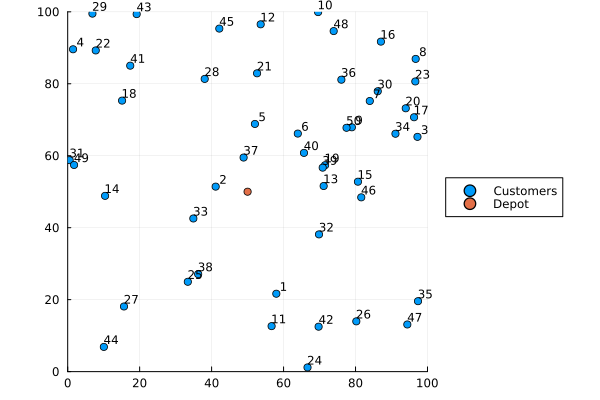

In [41]:
function plot_from_data(
    data::VehicleRoutingData,
)
    """Given a problem instance, plot it.
    """
    N = data.num_customers
    pl = plot(
        aspect_ratio = :equal, 
        # size = (500,500), 
        xlim = (0, 100), 
        ylim = (0, 100),
    )
    for i in 1:N
        annotate!(
            data.locations[i,1] + 2, 
            data.locations[i,2] + 2, 
            text("$i", 8)
        )
    end
    scatter!(
        data.locations[1:N, 1], 
        data.locations[1:N, 2], 
        label = "Customers",
    )
    scatter!(
        data.locations[[N+1], 1], 
        data.locations[[N+1], 2], 
        label = "Depot"
    )
    scatter!(
        legend = :outerright,
    )
    return pl
end
plot_from_data(data_large)

### b. MTZ formulation and solution

For CVRP, recall that its cousin the TSP has a simple formulation with a polynomial number of constraints, which doesn't scale very well. Let's write down the standard MTZ formulation for CVRP. Like in the previous recitation, we'll be considering the "open" CVRP, where routes must end (but not start) at the depot.


we are solving open cvrp with mtz formulation

Two binary var: w and u 
after serving, how full my vehicle is, 
link w and u, resrict (u_i )

extra w var that restrict going back to depot

w_0j (start at depot and go somewhere else (summing w only starting from nondepots))

solution is matrix

don't include arc going back to depot
don't care how big w_0j is (incentivize)


\begin{align}
    \min \quad 
    & \sum_{i \in \mathcal{N}_C} 
    \sum_{j \in \mathcal{N}}
    d_{ij} w_{ij}
    \\
    \text{s.t.} \quad 
    & \sum_{j \in \mathcal{N}} w_{ij} = 1 
    & \forall \ i \in \mathcal{N}_C
    \\
    & \sum_{j \in \mathcal{N}} w_{ij} = \sum_{j \in \mathcal{N}} w_{ji} 
    & \forall \ i \in \mathcal{N}
    \\
    & w_{ii} = 0 
    & \forall \ i \in \mathcal{N}
    \\
    & u_j \geq u_i + D_j - Q (1 - w_{ij}) 
    & \forall \ i \neq j \in \mathcal{N}_C,
    \\
    & D_i \leq u_i \leq Q 
    & \forall \ i \in \mathcal{N}_C 
    \\
    & w_{ij} \in \{0,1\}
    & \forall \ i \in \mathcal{N}, j \in \mathcal{N}.
\end{align}



The decision variables are:
- $w_{ij}$: binary variable indicating whether the arc $i \to j$ is traversed (by *some* vehicle)
- $u_i$: continuous variable indicating how full the vehicle is after visiting customer $i$

The first constraint enforces that each customer has at least one successor. The second maintains conservation of flow. The third prevents self-flows. The fourth enforces consistency between $w_{ij}$ and $u_i$. The bounds on $u_i$ enforce the capacity constraint.

In [56]:
function cvrp_mtz(
    data::VehicleRoutingData,
    ;
    verbose::Bool = true,
)
    N = data.num_customers
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        model, 
        "TimeLimit" => 5, 
        "OutputFlag" => (verbose ? 1 : 0),
    )
    @variable(model, w[1:N+1, 1:N+1], Bin)

    # Minimize total distance
    # Note: do not count arcs from depot to customer
    @objective(
        model,
        Min,
        sum(data.distances[i,j] * w[i,j] for i in 1:N, j in 1:N+1),
    )
    # Constraint requiring each customer to have a successor
    @constraint(
        model, 
        one_successor[i in 1:N],
        sum(w[i,j] for j in 1:N+1) == 1
    )
    # Constraint enforcing flow conservation at all nodes
    @constraint(
        model, 
        flow_conservation[i in 1:N+1],
        sum(w[i,j] for j in 1:N+1) 
        == sum(w[j,i] for j in 1:N+1)
    )
    # Constraint enforcing no self-arcs
    @constraint(
        model, 
        no_self_edges[i=1:N+1],
        w[i,i] == 0
    )
    # Variable designates the load of the vehicle after leaving customer i
    @variable(
        model, 
        u[1:N],
    )
    # Constraint enforces load to be in capacity constraints
    @constraint(
        model,
        capacity[i in 1:N],
        data.demand[i] ≤ u[i] ≤ data.capacity
    )
    # Constraint linking load variables to arc variables
    @constraint(
        model, 
        [i in 1:N, j in setdiff(1:N, i)], 
        u[j] 
        ≥ u[i] 
        + data.demand[j] 
        - data.capacity * (1 - w[i,j])
    )

    # warm start the solution with our initial routes, as before
    for i in 1:N
        set_start_value(w[i,N+1], 1)
        set_start_value(w[N+1,i], 1)
    end
    optimize!(model)
    return Dict(
        "objective_value" => objective_value(model),
        "solution" => value.(w)
    )
end

cvrp_mtz (generic function with 1 method)

Let's solve our 50-customer instance.

In [57]:
result = cvrp_mtz(data_large)

Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2652 rows, 2701 columns and 15151 nonzeros
Model fingerprint: 0x95800f3f
Variable types: 100 continuous, 2601 integer (2601 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e-01, 1e+02]
  Bounds range     [2e+00, 3e+01]
  RHS range        [1e+00, 3e+01]

User MIP start produced solution with objective 2028.85 (0.00s)
Loaded user MIP start with objective 2028.85

Presolve removed 101 rows and 101 columns
Presolve time: 0.02s
Presolved: 2551 rows, 2600 columns, 12450 nonzeros
Variable types: 50 continuous, 2550 integer (2550 binary)

Root relaxation: objective 4.418874e+02, 197 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

Dict{String, Any} with 2 entries:
  "solution"        => [0.0 -0.0 … -0.0 1.0; -0.0 0.0 … -0.0 1.0; … ; -0.0 -0.0…
  "objective_value" => 637.273

In [63]:
# matrix 1-N x 1-N, looking at the last row (N+1) produced sol looks like (all starting customer)
# 
function find_routes(
    sol::Array{Float64, 2},
)
    N = size(sol, 1) - 1
    routes = Vector{Int}[]
    start_nodes = findall(a -> (a > 0.5), sol[N+1,:])
    # look for value 1 in the last row where we now we can go back to depot
    # then starting our journey there to look for another 1 starting from that starting point
    #, tracing your route (ith row)
    for s in start_nodes
        route = Int[]
        current = s
        while true
            push!(route, current)
            if current == N+1
                break
            end
            current = findfirst(a -> (a > 0.5), sol[current,:])
        end
        push!(routes, route)
    end
    return routes
end

find_routes (generic function with 1 method)

In [64]:
routes = find_routes(result["solution"])

9-element Vector{Vector{Int64}}:
 [10, 48, 16, 8, 23, 30, 36, 51]
 [20, 17, 3, 34, 7, 9, 50, 6, 51]
 [24, 42, 11, 1, 51]
 [28, 45, 12, 21, 5, 37, 51]
 [31, 49, 14, 33, 51]
 [35, 47, 26, 32, 51]
 [43, 29, 4, 22, 41, 18, 2, 51]
 [44, 27, 25, 38, 51]
 [46, 15, 13, 39, 19, 40, 51]

In [65]:
function plot_from_routes(
    data::VehicleRoutingData,
    routes::Vector{Vector{Int}},
)
    """Given a problem instance and a corresponding route solution, plot it.
    """
    N = data.num_customers
    pl = plot_from_data(data)
    k = 0
    for route in routes
        k += 1
        plot!(
            data.locations[route, 1],
            data.locations[route, 2],
            label = "Vehicle $k",
        )
    end
    return pl
end


plot_from_routes (generic function with 1 method)

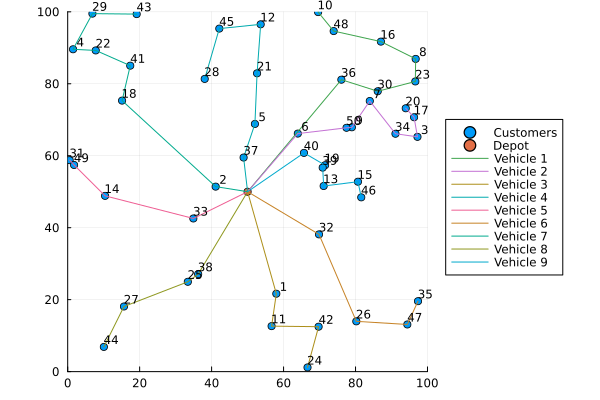

In [66]:
plot_from_routes(data_large, routes)

### c. Large-scale neighbourhood search

This looks a bit suboptimal, with a lot of routes crossing over (though this is possible in CVRP!).

We would like to "tweak" the solution by "destroying" some of the edges, then "repairing" the solution, hopefully with lower cost!

We can destroy the routes by removing $k$ edges, as follows:

In [70]:
function split_routes(
    routes::Vector{Vector{Int}}, 
    k::Int,
)
    """
    Given a list of routes, 'delete' `k` edges from them.
    """
    num_edges = [length(r) - 1 for r in routes]
    total_edges = sum(num_edges)
    cum_edges = cumsum(num_edges)
    splits = sort(shuffle(1:total_edges)[1:k])
    routes_to_split = [findfirst(x -> x ≥ s, cum_edges) for s in splits]
    places_to_split = [
        splits[i] - (
            routes_to_split[i] == 1 ? 
                0 : 
                cum_edges[routes_to_split[i] - 1]
            )
        for i = eachindex(splits)
    ]
    new_routes = Vector{Int}[]
    for (r, route) in enumerate(routes)
        if r in routes_to_split
            where_to_split = [
                places_to_split[i] 
                for i = eachindex(places_to_split) 
                    if routes_to_split[i] == r
            ]
            start = 1
            for j in where_to_split
                push!(new_routes, route[start:j])
                start = j + 1
            end
            push!(new_routes, route[start:end])
        else
            push!(new_routes, route)
        end
    end
    return new_routes
end

split_routes (generic function with 1 method)

For example, we can remove 7 edges.

In [75]:
Random.seed!(1234)
fragments = split_routes(routes, 10)

19-element Vector{Vector{Int64}}:
 [10]
 [48]
 [16, 8, 23]
 [30, 36, 51]
 [20]
 [17, 3, 34, 7, 9, 50, 6, 51]
 [24]
 [42, 11]
 [1, 51]
 [28, 45, 12, 21, 5, 37, 51]
 [31, 49, 14, 33, 51]
 [35, 47, 26, 32, 51]
 [43, 29, 4, 22]
 [41, 18, 2, 51]
 [44, 27, 25]
 [38]
 [51]
 [46, 15]
 [13, 39, 19, 40, 51]

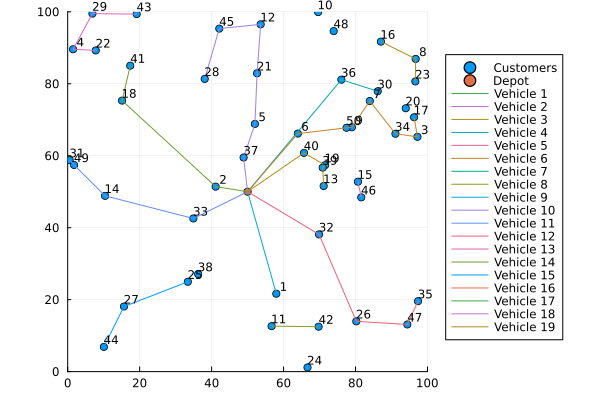

In [76]:
plot_from_routes(data_large, fragments)

The "fragments" look like this:

We can then tweak our CVRP formulation to keep fragments intact and simply connect them optimally.

In [77]:
function repair_cvrp_mtz(
    data::VehicleRoutingData,
    fragments::Vector{Vector{Int}}; 
    verbose::Bool = true,
)
    N = data.num_customers
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        model, 
        "TimeLimit" => 5, 
        "OutputFlag" => (verbose ? 1 : 0),
    )
    @variable(model, w[1:N+1, 1:N+1], Bin)

    # Minimize total distance
    # Note: do not count arcs from depot to customer
    @objective(
        model,
        Min,
        sum(data.distances[i,j] * w[i,j] for i in 1:N, j in 1:N+1),
    )
    # Constraint requiring each customer to have a successor
    @constraint(
        model, 
        one_successor[i in 1:N],
        sum(w[i,j] for j in 1:N+1) == 1
    )
    # Constraint enforcing flow conservation at all nodes
    @constraint(
        model, 
        flow_conservation[i in 1:N+1],
        sum(w[i,j] for j in 1:N+1) 
        == sum(w[j,i] for j in 1:N+1)
    )
    # Constraint enforcing no self-arcs
    @constraint(
        model, 
        no_self_edges[i=1:N+1],
        w[i,i] == 0
    )
    # Variable designates the load of the vehicle after leaving customer i
    @variable(
        model, 
        u[1:N],
    )
    # Constraint enforces load to be in capacity constraints
    @constraint(
        model,
        capacity[i in 1:N],
        data.demand[i] ≤ u[i] ≤ data.capacity
    )
    # Constraint linking load variables to arc variables
    @constraint(
        model, 
        [i in 1:N, j in setdiff(1:N, i)], 
        u[j] 
        ≥ u[i] 
        + data.demand[j] 
        - data.capacity * (1 - w[i,j])
    )

    # fiw our route fragments
    for fragment in fragments
        for i = 1:length(fragment)-1
            JuMP.fix(w[fragment[i], fragment[i+1]], 1)
        end
    end

    optimize!(model)
    return Dict(
        "objective_value" => objective_value(model),
        "solution" => value.(w)
    )
end 

repair_cvrp_mtz (generic function with 1 method)

Let's try to repair our fragments...

In [78]:
repair_result = repair_cvrp_mtz(data_large, fragments)

Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2652 rows, 2701 columns and 15151 nonzeros
Model fingerprint: 0xf3a40bed
Variable types: 100 continuous, 2601 integer (2601 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e-01, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 2525 rows and 2506 columns
Presolve time: 0.01s
Presolved: 127 rows, 195 columns, 1428 nonzeros
Variable types: 10 continuous, 185 integer (185 binary)
Found heuristic solution: objective 976.0988540

Root relaxation: objective 6.305861e+02, 31 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  630.58608   

Dict{String, Any} with 2 entries:
  "solution"        => [0.0 0.0 … 0.0 1.0; 0.0 0.0 … 0.0 1.0; … ; 0.0 0.0 … 0.0…
  "objective_value" => 637.273

In [81]:
repaired_routes = find_routes(repair_result["solution"])

9-element Vector{Vector{Int64}}:
 [10, 48, 16, 8, 23, 30, 36, 51]
 [20, 17, 3, 34, 7, 9, 50, 6, 51]
 [24, 42, 11, 1, 51]
 [28, 45, 12, 21, 5, 37, 51]
 [31, 49, 14, 33, 51]
 [35, 47, 26, 32, 51]
 [43, 29, 4, 22, 41, 18, 2, 51]
 [44, 27, 25, 38, 51]
 [46, 15, 13, 39, 19, 40, 51]

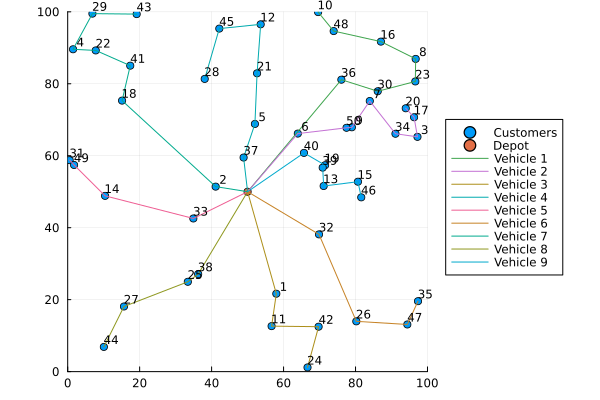

In [83]:
# Earlier solution
plot_from_routes(data_large, routes)

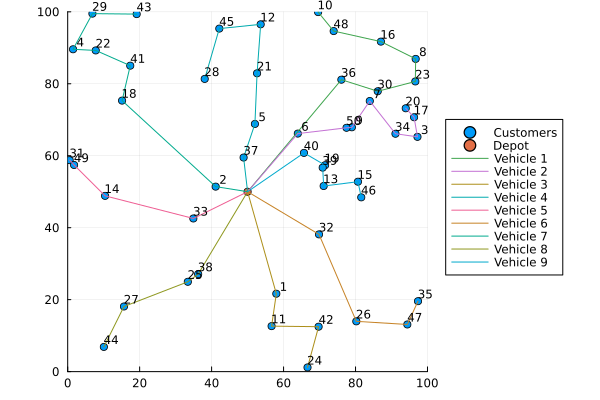

In [84]:
plot_from_routes(data_large, repaired_routes)

Looks like nothing changed. The solution is the same as before, with the same cost. But now we can do this iteratively!
To improve, i) how many edges we randomly pick 2) what edges to pick?

In [88]:
r = cvrp_mtz(data_large, verbose = false)
routes = find_routes(r["solution"])
println("Cost: $(r["objective_value"])")
Random.seed!(0)
for iteration in 1:10
    fragments = split_routes(routes, 20)
    r = repair_cvrp_mtz(data_large, fragments, verbose = false)
    routes = find_routes(r["solution"])
    println("Cost: $(r["objective_value"])")
end

Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Cost: 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Cost: 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Cost: 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Cost: 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Cost: 637.2730875988483
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Cost: 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Cost: 632.1850054196324
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Cost: 632.1850054196325
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Cost: 632.1850054196323
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Cost: 632.1850054196323
Set parameter TimeLimit to value 5
Set parameter TimeLimit t

There is a tradeoff here: the more edges we remove, the larger the neighborhood we have to explore, and the more we will gain from an iteration, but the harder it becomes to optimize over the neighborhood. Let's explore this a little bit, by trying to vary the number of edges we remove (and thus the number of fragments we create).

In [89]:
num_fragments_range = [5, 10, 15, 20]
costs = Dict(
    num_fragments => Float64[]
    for num_fragments in num_fragments_range
)
times = Dict(
    num_fragments => Float64[]
    for num_fragments in num_fragments_range
)
Random.seed!(1234)
for num_fragments in num_fragments_range
    println("Number of destroyed edges: $num_fragments")
    push!(
        times[num_fragments], 
        @elapsed r = cvrp_mtz(data_large, verbose = false)
    )
    push!(costs[num_fragments], r["objective_value"])
    println("0 - ", r["objective_value"])
    for iteration in 1:30
        routes = find_routes(r["solution"])
        fragments = split_routes(routes, num_fragments)
        push!(
            times[num_fragments], 
            @elapsed r = repair_cvrp_mtz(data_large, fragments, verbose = false)
        )
        println("$t - ", r["objective_value"])
        push!(costs[num_fragments], r["objective_value"])
    end
end

Number of destroyed edges: 5
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
0 - 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
1 - 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
2 - 637.2730875988483
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
3 - 637.2730875988483
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
4 - 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
5 - 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
6 - 637.2730875988483
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
7 - 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
8 - 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
9 - 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter Ti

635.90123182515
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
15 - 635.9012318251499
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
16 - 635.90123182515
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
17 - 635.9012318251499
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
18 - 635.9012318251499
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
19 - 635.90123182515
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
20 - 635.9012318251499
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
21 - 635.90123182515
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
22 - 635.90123182515
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
23 - 635.9012318251499
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
24 - 635.90123182515
Set parameter TimeLimit to value 5
Set parameter TimeLimit to va

Let's look at how much progress we made in each iteration. 

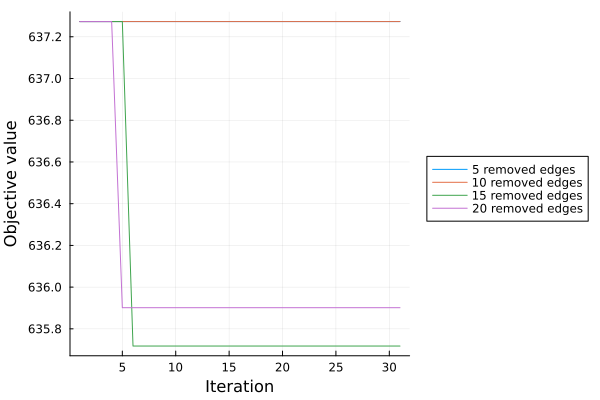

In [106]:
p = plot(
    xlabel = "Iteration",
    ylabel = "Objective value",
)
for num_fragments in num_fragments_range
    plot!(
        costs[num_fragments], 
        label = "$num_fragments removed edges"
    )
end
plot!(legend = :outerright)

Increasing the size of the neighborhood (the number of fragments, and thus the number of possible new routes) allows us to find better solutions. So is our best bet to destroy 20 edges in each iteration?

Keep in mind that using a smaller neighborhood size also means each iteration is faster. We can plot progress as a function of time instead of number of iterations to observe this effect.

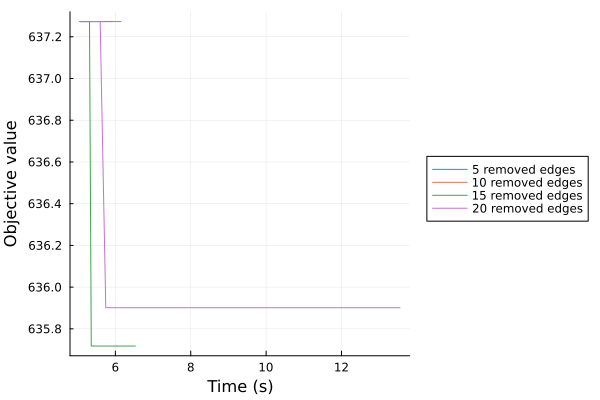

In [103]:
p = plot(
    xlabel = "Time (s)",
    ylabel = "Objective value",
)
for num_fragments in num_fragments_range
    plot!(
        cumsum(times[num_fragments]),
        costs[num_fragments], 
        label = "$num_fragments removed edges"
    )
end
plot!(legend = :outerright)

Given this plot, we may wish to reconsider our choice to destroy 20 edges at each iteration. Deleting 15 edges seems to make as good progress in less time!

(Obviously, if we were tuning this parameter for real, we would need to average over multiple runs, etc.)

We can also select the neighborhood size **adaptively**. For example, we could delete 5 edges as a baseline. If we do not find a new solution, we increase our neighborhood size to 10 edges, then 15 edges, 20 edges, etc. If we **do** find a new solution, we reduce the neighborhood size back from 20 to 15 or 15 to 10, etc.

We can easily implement this as follows:

In [98]:
adaptive_times = []
adaptive_costs = []
Random.seed!(1)
push!(adaptive_times, @elapsed r = cvrp_mtz(data_large, verbose = false))
total_cost = r["objective_value"]
push!(adaptive_costs, total_cost)
num_fragments_range = [5, 10, 15, 20]
fragment_index = 1
println("0 - $(num_fragments_range[fragment_index]) - ", total_cost)
for iteration in 1:30
    routes = find_routes(r["solution"])
    fragments = split_routes(routes, num_fragments_range[fragment_index])
    push!(adaptive_times, @elapsed r = repair_cvrp_mtz(data_large, fragments, verbose = false))
    total_cost = r["objective_value"]
    println("$iteration - $(num_fragments_range[fragment_index]) - ", total_cost)
    # adapt neighborhood size
    if abs(total_cost - adaptive_costs[end]) < 1e-6
        # If no change in objective, increase neighborhood size
        fragment_index = min(length(num_fragments_range), fragment_index + 1)
    else
        # If change in objective, decrease neighborhood size
        fragment_index = max(1, fragment_index - 1)
    end
    push!(adaptive_costs, total_cost)
end

Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
0 - 5 - 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
1 - 5 - 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
2 - 10 - 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
3 - 15 - 637.2730875988483
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
4 - 20 - 637.2730875988481
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
5 - 20 - 637.2730875988483
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
6 - 20 - 637.2730875988482
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
7 - 20 - 637.2730842541229
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
8 - 15 - 637.2730875988483
Set parameter TimeLimit to value 5
Set parameter TimeLimit 

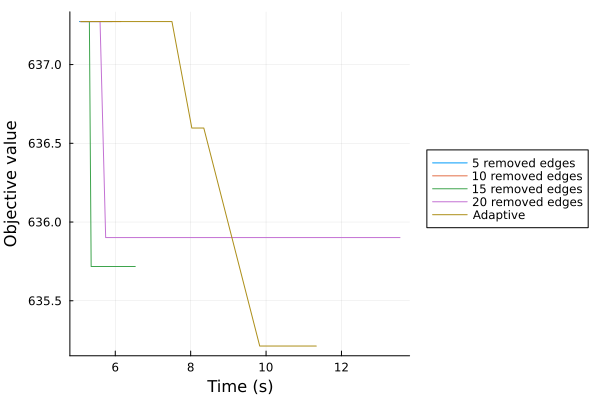

In [107]:
p = plot(
    xlabel = "Time (s)",
    ylabel = "Objective value",
)
for num_fragments in num_fragments_range
    plot!(
        cumsum(times[num_fragments]),
        costs[num_fragments], 
        label = "$num_fragments removed edges"
    )
end
plot!(
    cumsum(adaptive_times),
    adaptive_costs, 
    label = "Adaptive"
)
plot!(legend = :outerright)

The results are pretty good, and give us a way to potentially reach better solutions! Or maybe we just got lucky.

The huge advantage of "destroy and repair" approaches is just how easy it is to transform your slow MIP formulation in JuMP into a fast custom heuristic.

## 2 - Nonlinear mixed-integer optimization

In the final part of this recitation, we will provide a preview of nonlinear discrete optimization. Specifically, we will code up some exact methods for sparse linear regression.

### 2.1 Linear regression

Suppose we have a data matrix $A$, and vector $b$, and we want to estimate a vector $x$ such that:

$$
\underset{x}{\min}\ || Ax-b ||_2^2
$$

One way of expressing it in JuMP is through the following formulation:

$$\begin{align}
\min\quad& \sum_i z_i^2 \\
\text{s.t.}\quad & z_i = a_i^\top x - b_i &\forall i
\end{align}$$

where $a_i^\top$ is the $i$-th row of the data matrix $A$.

Let's first create some data $A$ and $b$, of dimensions $n$ times $p$ and $n$ times $1$, respectively.

In [135]:
n = 1000
p = 15

15

We let $b=Ax^{\text{real}}+\varepsilon$, where $\varepsilon$ is an independent noise term.

In [138]:
Random.seed!(1234)
real_x = 10 * randn(p)
A = randn(n, p)
b = A * real_x + randn(n) * sqrt(n) * 0.1
;

We can formulate the problem directly in JuMP.

In [140]:
function linear_regression(A, b)
    """
    Performs linear regression with data matrix `A` and observed values `b`,
    with a least-squares objective.
    """
    m = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(m, "TimeLimit" => 10)
    n, p = size(A)
    @variable(m, x[1:p])
    @variable(m, z[1:n])
    @objective(m, Min, sum(z[i]^2 for i in 1:n))
    @constraint(m, 
        [i=1:n], 
        z[i] == sum(A[i,j] * x[j] for j in 1:p) - b[i]
    )
    optimize!(m)
    return value.(x)
end

linear_regression (generic function with 1 method)

Let's solve it for our example:

In [141]:
x_val = linear_regression(A, b);

Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 10
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1000 rows, 1015 columns and 16000 nonzeros
Model fingerprint: 0x320cb7fb
Model has 1000 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-04, 4e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+02]
Presolve time: 0.00s
Presolved: 1000 rows, 1015 columns, 16000 nonzeros
Presolved model has 1000 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 15
 Free vars  : 1015
 AA' NZ     : 1.500e+04
 Factor NZ  : 1.612e+04 (roughly 1 MB of memory)
 Factor Ops : 2.572e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Comp

And let's compare to the true value of $x$:

In [142]:
@show x_val
@show real_x
@show norm(A * x_val .- b)^2

x_val = [9.70481552745714, -9.683395181109969, 9.084372218267205, -0.07742564007804544, -5.929547040601295, -14.57349745657534, 27.031703797774632, 15.129705289311412, -2.101797643055555, 7.721678219811015, -12.150730948105272, 11.052549385854357, 12.25306588922379, -0.8503103524933939, 17.09522950957706]
real_x = [9.706563288552143, -9.792184115351997, 9.018608835940936, -0.3280312924463938, -6.007922233555611, -14.45177115286233, 27.074239417157806, 15.244478634355955, -2.0563037602802727, 7.707031750912096, -12.139401711703544, 10.914985820684816, 12.200437967121276, -0.7583161525464888, 17.24189934074888]
norm(A * x_val .- b) ^ 2 = 9224.253202983236


9224.253202983236

Close enough!

### 2.2 Sparse regression

In practice, many real-world signals are "sparse" - most of the elements are 0, and only a few elements actually matter.

In [144]:
Random.seed!(778)
real_x = shuffle(vcat(2 * randn(floor(Int, p / 3)), zeros(p - floor(Int, p / 3))))
@show real_x
b = A * real_x + randn(n)
;

real_x = [0.0, -1.550929354341868, 0.0, 0.0, 0.0, 0.0, 0.0, -0.8022265721487025, 0.0, -0.998130049681668, 1.4564674678675649, 0.0, 0.0, 0.0, -2.633797589545033]


We can formulate the sparse regression problem using the following big-M formulation:


$$\begin{align}
\min\quad & f(z) = \sum_i z_i^2 \\
\text{s.t.}\quad & z_i = a_i^\top x - b &\forall i\in [n] \\
&x_j \leq My_j &\forall j \in [p]\\
&x_j \geq -My_j &\forall j\in[p]\\
&\sum_{j=1}^p y_j \leq k \\
&y_j\in\{0,1\}&\forall j=1,\dots,p
\end{align}$$

This is a mixed-integer nonlinear problem, though it is convex, which means the relaxations are (relatively) easy to solve.

However, instead of solving it directly using Gurobi's nonlinear branch and bound solver, we will use an **outer approximation**.

Quadratic functions are convex, which means they are greater than their linear approximation at any point, i.e. for any $z^0$, we know that

$$f(z) \ge f(z^0) + f'(z^0) (z - z^0).$$

We can actually re-write $f(z)$ as

$$f(z)=\max_{z^0\in\mathbb{R}^n}f(z^0) + f'(z^0)^T (z - z^0),$$

i.e.

$$f(z) = \sum_i z_i^2 = \max_{z^0\in\mathbb{R}^n}\sum_{i=1}^n (z^0_i)^2 + 2 (z^0)^T (z - z^0)$$

This is a really large number of linear functions... an uncountable number, in fact. But we only need a few of them to get a good outer approximation, so we can generate them using lazy constraints!

In [129]:
function sparse_regression(A, b, k)
    """
    Performs sparse linear regression with data matrix `A` and observed values `b`,
    with at most `k` nonzero coefficients. Uses outer approximation and lazy constraints.
    """
    M = 10
    n, p = size(A)
    
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        model, 
        "TimeLimit" => 30, 
        "LazyConstraints" => 1,
    )
    @variable(model, x[1:p])
    @variable(model, y[1:p], Bin)
    @variable(model, z[1:n])
    @variable(model, η ≥ 0)

    @objective(model, Min, η)

    @constraint(
        model, 
        [i=1:n], 
        z[i] == sum(A[i,j] * x[j] for j in 1:p) - b[i]
    )
    @constraint(
        model, 
        [j=1:p], x[j] ≤ M * y[j]
    )
    @constraint(
        model, 
        [j=1:p], x[j] ≥ - M * y[j]
    )
    @constraint(
        model, 
        sum(y[j] for j in 1:p) ≤ k
    )
    
    "Callback function"
    function add_outer_approximation_cuts(cb_data)
        status = callback_node_status(cb_data, model)
        if status == MOI.CALLBACK_NODE_STATUS_INTEGER
            # get value of current solution
            z_0 = [callback_value(cb_data, z[i]) for i = 1:n]
            out = @build_constraint(
                η ≥ sum(z_0[i]^2 for i = 1:n) 
                + 2 * sum(z_0[i] * (z[i] - z_0[i]) for i = 1:n)
            )
            MOI.submit(model, MOI.LazyConstraint(cb_data), out)
        end
    end
    # set callback function and attach to model
    MOI.set(model, MOI.LazyConstraintCallback(), add_outer_approximation_cuts)

    optimize!(model)
    return value.(x)
end

sparse_regression (generic function with 1 method)

Let's try it on our example!

In [146]:
x_val = sparse_regression(A, b, floor(p / 3))

Set parameter TimeLimit to value 30
Set parameter LazyConstraints to value 1
Set parameter LazyConstraints to value 1
Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1031 rows, 1031 columns and 16075 nonzeros
Model fingerprint: 0xca264331
Variable types: 1016 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+01]
Presolve removed 1000 rows and 1000 columns
Presolve time: 0.00s
Presolved: 31 rows, 31 columns, 75 nonzeros
Variable types: 16 continuous, 15 integer (15 binary)

Root relaxation: objective 0.000000e+00, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


15-element Vector{Float64}:
  0.0
 -1.5138117801959898
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.7559063879344017
  0.0
 -1.074829511139052
  1.4989376808600041
  0.0
  0.0
  0.0
 -2.602630750300629

In [148]:
@show norm(A * x_val .- b) ^ 2
@show norm(A * real_x .- b) ^ 2
[x_val real_x]

norm(A * x_val .- b) ^ 2 = 1026.9287161412944
norm(A * real_x .- b) ^ 2 = 1039.4121281578473


15×2 Matrix{Float64}:
  0.0        0.0
 -1.51381   -1.55093
  0.0        0.0
  0.0        0.0
  0.0        0.0
  0.0        0.0
  0.0        0.0
 -0.755906  -0.802227
  0.0        0.0
 -1.07483   -0.99813
  1.49894    1.45647
  0.0        0.0
  0.0        0.0
  0.0        0.0
 -2.60263   -2.6338

We can also use **ridge regression** as a means to perform regularization and avoid overfitting.Instead of just minimizing the mean squared error, we put a penalty on the sum of squares of the coefficients $x$.

In other words, our objective becomes:

$$f(z) + \lambda g(x)=\sum_i z_i^2+\lambda \sum_j x_j^2,$$

where $\lambda$ is the tradeoff parameter.

The second part of the objective is again a convex quadratic form, so as before, we can write:

$$g(x) = \sum_j x_j^2 = \max_{x^0\in\mathbb{R}^p}\sum_{j=1}^p (x^0_j)^2 + 2 (x^0)^T (x - x^0)$$

In [149]:
function sparse_ridge_regression(A, b, k, λ)
    """
    Performs sparse linear regression with data matrix `A` and observed values `b`,
    with at most `k` nonzero coefficients. 
    Adds a ridge regularization term with parameter `λ`.
    Uses outer approximation and lazy constraints.
    """
    M = 10
    n, p = size(A)
    
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        model, 
        "TimeLimit" => 30, 
        "LazyConstraints" => 1,
    )
    @variable(model, x[1:p])
    @variable(model, y[1:p], Bin)
    @variable(model, z[1:n])
    # objective
    @variable(model, η ≥ 0)
    @variable(model, μ ≥ 0)
    @objective(model, Min, η + λ * μ)

    @constraint(
        model, 
        [i=1:n], 
        z[i] == sum(A[i,j] * x[j] for j in 1:p) - b[i]
    )
    @constraint(
        model, 
        [j=1:p], 
        x[j] ≤ M * y[j]
    )
    @constraint(
        model, 
        [j=1:p], 
        x[j] ≥ - M * y[j]
    )
    @constraint(
        model, 
        sum(y[j] for j in 1:p) ≤ k
    )
    
    "Callback function"
    function add_outer_approximation_cuts(cb_data)
        status = callback_node_status(cb_data, model)
        if status == MOI.CALLBACK_NODE_STATUS_INTEGER
            # get value of current solution
            z_0 = [callback_value(cb_data, z[i]) for i = 1:n]
            out = @build_constraint(
                η ≥ sum(z_0[i]^2 for i = 1:n) 
                + 2 * sum(z_0[i] * (z[i] - z_0[i]) for i = 1:n)
            )
            MOI.submit(model, MOI.LazyConstraint(cb_data), out)
            x_0 = [callback_value(cb_data, x[j]) for j = 1:p]
            ridge = @build_constraint(
                μ ≥ sum(x_0[j]^2 for j = 1:p) 
                + 2 * sum(x_0[j] * (x[j] - x_0[j]) for j = 1:p)
            )
            MOI.submit(model, MOI.LazyConstraint(cb_data), ridge)
        end
    end
    # set callback function and attach to model
    MOI.set(model, MOI.LazyConstraintCallback(), add_outer_approximation_cuts)

    optimize!(model)
    return value.(x)
end

sparse_ridge_regression (generic function with 1 method)

We can apply this method to our data:

In [150]:
x_ridge = sparse_ridge_regression(A, b, floor(p / 3), 100)

Set parameter TimeLimit to value 30
Set parameter LazyConstraints to value 1
Set parameter LazyConstraints to value 1
Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1031 rows, 1032 columns and 16075 nonzeros
Model fingerprint: 0xcb626a6f
Variable types: 1017 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+01]
Presolve removed 1000 rows and 1000 columns
Presolve time: 0.00s
Presolved: 31 rows, 32 columns, 75 nonzeros
Variable types: 17 continuous, 15 integer (15 binary)

Root relaxation: objective 0.000000e+00, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


15-element Vector{Float64}:
  0.0
 -1.3886018126410495
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.6774110401663627
  0.0
 -0.9829407079894983
  1.3686083117618912
  0.0
  0.0
  0.0
 -2.365320499251693

Now we compare to our previous solution:

In [151]:
[x_ridge x_val real_x]

15×3 Matrix{Float64}:
  0.0        0.0        0.0
 -1.3886    -1.51381   -1.55093
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.0        0.0        0.0
 -0.677411  -0.755906  -0.802227
  0.0        0.0        0.0
 -0.982941  -1.07483   -0.99813
  1.36861    1.49894    1.45647
  0.0        0.0        0.0
  0.0        0.0        0.0
  0.0        0.0        0.0
 -2.36532   -2.60263   -2.6338

We can verify the reduction in overfitting and increase in bias using some test data sampled from the same distribution.

In [153]:
Random.seed!(7712)
A_test = randn(n, p)
b_test = A_test * real_x + randn(n);
println("Sparse model:\t", norm(A_test * x_val .- b_test) ^ 2)
println("Ridge model:\t", norm(A_test * x_ridge .- b_test) ^ 2)
println("True model:\t", norm(A_test * real_x .- b_test) ^ 2)

Sparse model:	1012.2356883569271
Ridge model:	1159.3918671968509
True model:	990.4443114769994


In the results above, we see that the ridge regression model yields smaller coefficients in general - this protects against overfitting, but introduces bias (the "Bias-Variance tradeoff" -- Google it!)

These are further considerations that one needs to be careful about:
- Data normalization and scaling: these can make a lot of difference for such methods
- Hyperparameter selection: what is a good choice for $\lambda$? We might need to choose $\lambda$ via some cross-validation procedure i.e. from data.
- Hyperparameter selection part 2: How did we know there were 5 true features out of 15? Spoiler: in practice we won't. In practice, we can try all possible small values, and see where there is a "kink" in the error curve (the elbow method) -- but this is not a science.